In [24]:
import sys
sys.path.append('..')

In [25]:
import os
import pickle

import tqdm
import numpy as np
import seaborn as sns
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.svm import SVC

from src import credit_utils as cred

## Load simulation data

In [26]:
DATA_BASE_PATH = '../out'
REPORT_NAME_REGEX = 'group_poisoning'

In [27]:
IMAGES_DIR = '../images'
!mkdir -p {IMAGES_DIR}

In [28]:
report_filenames = !ls {DATA_BASE_PATH} | grep {REPORT_NAME_REGEX}
print('Number of reports:', len(report_filenames))

Number of reports: 10


In [29]:
report_paths = [os.path.join(DATA_BASE_PATH, name) for name in report_filenames]
sim_datasets = []
for report_path in report_paths:
    with open(report_path, 'rb') as f:
        cum_group_scores, cum_group_datasets = pickle.load(f)
    sim_datasets.append(cum_group_datasets)    

## Restore the poisoned models

In [30]:
df, df_X, df_y = cred.load_dataframes('../data/german_credit_data.csv')
X, y, X_train, y_train, X_test, y_test = cred.to_numpy_data(df_X, df_y)
clf, svm_params = cred.train_model(X_train, y_train, X_test, y_test)

Shape of X: (1000, 38). Shape of y: (1000,).
Best score is: 74.22%. Best params is: {'C': 10, 'kernel': 'rbf'}.
Test score is: 77.00%.


In [31]:
models_by_sim = []
for sim in tqdm.tqdm_notebook(sim_datasets):
    sim_models = []
    for dataset in sim:
        X_train_adv, y_train_adv = dataset
        clf_poisoned = SVC(probability=True, **svm_params).fit(
            X_train_adv, y_train_adv)
        sim_models.append(clf_poisoned)
    models_by_sim.append(sim_models)

## Visualize the effects of poisoning

In [32]:
sns.set(font_scale=1.4, style='white')

In [33]:
def score(clf, group):
    return np.mean(clf.predict(group) == 1)

Target group

In [34]:
target_group_sel = (df['Checking account_little'] == 1) & \
                   (df['Saving accounts_little'] == 1) & \
                   (df['Risk_good'] == 1) & \
                   (clf.predict(X) == 0).astype(bool)
                    

target_group = X[target_group_sel]
print('Size', len(target_group), '/ Acceptance rate:', score(clf, target_group))

Size 22 / Acceptance rate: 0.0


Control group 0: everyone but the target group

In [35]:
control_group_0_sel = np.ones(len(X), dtype=bool) ^ target_group_sel
control_group_0 = X[control_group_0_sel]
print('Size', len(control_group_0), '/ Acceptance rate:', score(clf, control_group_0))

Size 978 / Acceptance rate: 0.8384458077709611


In [36]:
groups = {
    'Target': target_group,
    'Everyone else': control_group_0,
}
group_scores_df = pd.DataFrame(
    columns=['sim', 'poison_size', 'Group', 'score_change'])

for sim_num, sim_models in enumerate(tqdm.tqdm_notebook(models_by_sim)):
    for poison_size, clf_adv in enumerate([clf] + sim_models):
        for group_id, group in groups.items():
            current_score_change = score(clf_adv, group) - score(clf, group)
            group_scores_df = group_scores_df.append(
                {'sim': sim_num,
                 'poison_size': poison_size,
                 'Group': group_id, # Need to capitalize the name for the plot.
                 'score_change': current_score_change * 100},
                ignore_index=True)

group_scores_df.sim = group_scores_df.sim.astype(int)
group_scores_df.poison_size = group_scores_df.poison_size.astype(int)

/home/bogdan/Workspace/padML-code/venv/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


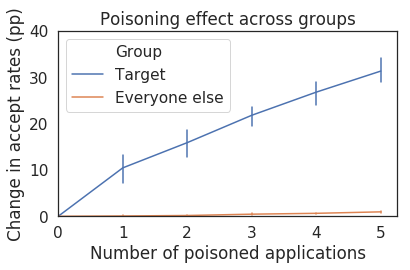

In [37]:
fig, ax = plt.subplots()

sns.lineplot(data=group_scores_df,
             x='poison_size', y='score_change', hue='Group',
             ci=99, err_style='bars', ax=ax)

ax.set_ylim(0, 40)
ax.set_xlim(0, 5.25)
ax.set_ylabel("Change in accept rates (pp)")
ax.set_xlabel("Number of poisoned applications")
ax.set_title("Poisoning effect across groups")

fig.tight_layout()
plt.savefig(os.path.join(IMAGES_DIR, 'poisoning_comparison.pdf'))

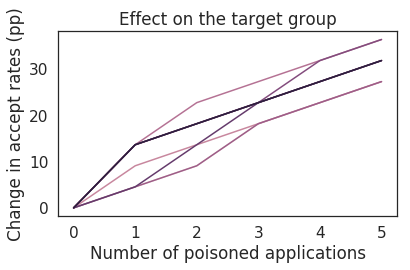

In [38]:
fig, ax = plt.subplots()
sns.lineplot(data=group_scores_df[group_scores_df.Group == 'Target'],
             x='poison_size', y='score_change', hue='sim', ci=None, legend=False,
             err_style='bars', ax=ax)

ax.set_ylabel("Change in accept rates (pp)")
ax.set_xlabel("Number of poisoned applications")
ax.set_title('Effect on the target group')

fig.tight_layout()
plt.savefig(os.path.join(IMAGES_DIR, 'poisoning_trajectories.pdf'))